# Real estate ROI calculator 

## Configurables
Change your url and location here

In [1]:
import datetime

#Replace this url with the url of your search results
#url = 'https://www.immobilienscout24.de/Suche/de/berlin/berlin/wohnung-kaufen?enteredFrom=one_step_search'
# state/city
# location = "berlin/berlin"
# location = "baden-wuerttemberg/pforzheim"
# location = "niedersachsen/lueneburg-kreis"
location = "bayern/fuerth-kreis"

# location = "sachsen-anhalt/magdeburg"
propertyType = 'wohnung'
# url_to_crawl = 'https://www.immobilienscout24.de/Suche/de/rheinland-pfalz/alzey-worms-kreis/wohnung-kaufen?enteredFrom=result_list'
url_to_crawl = 'https://www.immobilienscout24.de/Suche/de/' + location + '/'+propertyType+'-kaufen?enteredFrom=result_list'

actualDate = datetime.date.today()
actualDate = actualDate.strftime('%Y-%m-%d')
city = location.split('/')[1]
file_name_csv_raw = 'immobilienscout_result_'+ city + '_' + + actualDate + '.csv'
file_folder = 'data'
file_path = file_folder + '/' +  file_name_csv_raw

# Your variables to change
rent_price_index = 9
equity_percentage = 0.20
interest_rate = 0.01
mortgage_payment_rate = 0.02

# Standard percentages
notary_percentage = 0.015
transfer_tax_percentage = 0.05
land_registry_tax_percentage = 0.005
additional_costs_rate_per_m2 = 0.9 

## Setup

In [2]:
import urllib.request
import scrapy
from scrapy.crawler import CrawlerProcess
from scrapy import Selector
import selenium
from selenium import webdriver
import chromedriver_binary
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 200)

import json
import re
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:

columns = ['id_expose', 'url', 'title', 'address', 'contact_person', 'telephone', 'mobile', 'fax', 'price_purchase', 'estimated_monthly_rate', 'rooms', 'living_area_m2', 'furnishing', 'flat_type', 'floor', 'floor_total', 'bedrooms', 'commission_buyer_rate', 'maintenance_cost', 'construction_year', 'object_state', 'heating_type', 'energy_efficiency_class', 'location']

df_base = pd.DataFrame(columns = columns)

options = Options()
options.headless = True

crawler_name = 'scrapper_immobilienscout'

base_uri = 'immobilienscout24.de'
base_url = 'https://www.immobilienscout24.de'

In [4]:
driver = webdriver.Chrome()
# OLD configuration
#driver = webdriver.Chrome(options=options, executable_path="chromedriver.exe")

class Scrap_immobilienscout(scrapy.Spider):
    
    name = crawler_name
    
    def start_requests(self):
        first_page = urllib.request.urlopen(url_to_crawl)
        max_pages = first_page.read()
        max_pages = max_pages.decode("utf8")
        first_page.close()

        max_pages_selector = Selector(text = max_pages)
        max_pages = max_pages_selector.xpath('//select[@aria-label="Seitenauswahl"]/option[last()]/@value').extract_first()
        max_pages = int(max_pages) if max_pages is not None else 1
        
        base_url = url_to_crawl.replace('enteredFrom=one_step_search', '')
        
        for page_number in range(max_pages):
            url = base_url + 'pagenumber=' + str(page_number + 1)
            yield scrapy.Request(url, callback = self.parse_properties_list)
    
    def parse_properties_list(self, response):
        
        property_urls = response.xpath('//a[contains(@class, "result-list-entry__brand-title-container")]/@href').extract()
        
        for url in property_urls:
            if base_uri not in url:
                url = base_url + url + '#/'
                driver.get(url)
                src = driver.page_source
                self.scrap_property(src, url)
    
    # TODO rename variables
    # TODO clarify default values
    # TODO fix parse issues (int, roundings, etc.)
    def scrap_property(self, src, url):
        sel = Selector(text = src)

        id_expose = '' # TODO get expose substring of url
        
        title = sel.css('h1#expose-title ::text').extract_first()
        
        address = sel.xpath('//div[@class="address-block"]//span[@class="block font-nowrap print-hide"]//text()').extract_first()
        address = address.strip() if address is not None else ''

        region = sel.css('span.zip-region-and-country::text').extract_first()
        address += ' ' + region if region is not None else ''
        
        contact_person = sel.xpath('//div[@data-qa="contactName"]//text()').extract_first()
        contact_person = contact_person if contact_person is not None else ''
        
        phone = sel.xpath('//script//text()').extract_first()
        phone = phone if phone is not None else ''

        telefon = re.findall('"phoneNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        telefon = telefon[0].replace(' ', '') if len(telefon) > 0 else None
        
        mobil = re.findall('"cellPhoneNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        mobil = mobil[0] if len(mobil) > 0 else ''
        mobil = mobil.replace(' ', '')

        fax = re.findall('"faxNumber":\{"contactNumber":"(\+?[0-9 ]*)"\}', phone)
        fax = fax[0] if len(fax) > 0 else ''
        fax = fax.replace(' ', '')
        
        price = sel.xpath('//dd[contains(@class, "is24qa-kaufpreis")]//text()').extract_first()
        price = re.sub('[^0-9]', '', price) if price is not None else 0
        price = int(price)
        
        estimated_monthly_rate = sel.xpath('//span[contains(@class, "monthly-rate-result") and contains(@class, "monthly-rate-value")]//text()').extract_first()
        estimated_monthly_rate = re.sub('[^0-9]', '', estimated_monthly_rate) if estimated_monthly_rate is not None else 0
        estimated_monthly_rate = int(estimated_monthly_rate)
        
        rooms_count = sel.xpath('//dd[contains(@class,"is24qa-zimmer")]/text()').extract_first()
        rooms_count = float(rooms_count.replace(" ","").replace(",",".") ) if rooms_count is not None else 0
        
        living_area = sel.xpath('//dd[contains(@class, "is24qa-wohnflaeche-ca")]/text()').extract_first()
        living_area = re.sub('[^0-9\.]', '', living_area.replace(",",".")) if living_area is not None else 0
        living_area = float(living_area)
        
        furnishing = sel.xpath('//div[contains(@class, "criteriagroup") and contains(@class, "boolean-listing")]//span[contains(@class, "palm-hide")]/text()').extract()
        furnishing = list(set(furnishing))
        furnishing = [t for t in furnishing if t != ' ']
        furnishing = furnishing if len(furnishing) > 0 else ''
        
        flat_type = sel.xpath('//dd[contains(@class, "is24qa-typ")]/text()').extract_first()
        
        floor = sel.xpath('//dd[contains(@class, "is24qa-etage")]//text()').extract_first()
        floor = floor if floor is not None else ''
        floor = re.findall('[0-9]+', floor)
        total_floors = int(floor[1]) if len(floor) > 1 else 0
        floor = int(floor[0]) if len(floor) > 0 else 0
        
        bedroom = sel.xpath('//dd[contains(@class, "is24qa-schlafzimmer")]//text()').extract_first()
        bedroom = re.sub('[^0-9]', '', bedroom) if bedroom is not None else 0
        bedroom = int(bedroom)
        
        allowance = sel.xpath('//dd[contains(@class, "is24qa-hausgeld")]//text()').extract_first()
        allowance = re.sub('[^0-9]', '', allowance) if allowance is not None else 0
        allowance = int(allowance)
        
        commission = sel.xpath('//dd[contains(@class, "is24qa-provision")]/text()').extract_first()
        
        if commission is not None:
            try:
                commission = re.search('[0-9]+,?[0-9]*', commission).group() 
            except:
                commission = ''
        else:
            commission = ''

        commission = commission.replace(',', '.')
        commission = float(commission) if len(commission) > 0 else 0
        
        construction_year = sel.xpath('//dd[contains(@class, "is24qa-baujahr")]//text()').extract_first()
        
        object_state = sel.xpath('//dd[contains(@class, "is24qa-objektzustand")]//text()').extract_first()
        
        heatingy_type = sel.xpath('//dd[contains(@class, "is24qa-heizungsart")]//text()').extract_first()
        
        energy_efficiency_class = sel.xpath('//dd[contains(@class, "is24qa-energieeffizienzklasse")]//text()').extract_first()
        energy_efficiency_class = energy_efficiency_class if energy_efficiency_class is not None else ''
        
        location = sel.xpath('//pre[contains(@class, "is24qa-lage")]/text()').extract_first()

        lst_row = [id_expose, url, title, address, contact_person, telefon, mobil, fax, price, estimated_monthly_rate, rooms_count, living_area, furnishing, flat_type, floor, total_floors, bedroom, commission, allowance, construction_year, object_state, heatingy_type, energy_efficiency_class, location]
        df_base.loc[len(df_base)] = lst_row
        df_base.to_csv(file_path, index=False)
        
process = CrawlerProcess()
process.crawl(Scrap_immobilienscout)
process.start()
# TODO unblock process. See: https://docs.scrapy.org/en/latest/topics/practices.html 

76189#/"}
2020-07-20 22:50:42 [urllib3.connectionpool] DEBUG: http://127.0.0.1:49153 "POST /session/6461df6c78ade74a150916942fb113cd/url HTTP/1.1" 200 14
2020-07-20 22:50:42 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-20 22:50:42 [selenium.webdriver.remote.remote_connection] DEBUG: GET http://127.0.0.1:49153/session/6461df6c78ade74a150916942fb113cd/source {}
2020-07-20 22:50:42 [urllib3.connectionpool] DEBUG: http://127.0.0.1:49153 "GET /session/6461df6c78ade74a150916942fb113cd/source HTTP/1.1" 200 839645
2020-07-20 22:50:42 [selenium.webdriver.remote.remote_connection] DEBUG: Finished Request
2020-07-20 22:50:42 [selenium.webdriver.remote.remote_connection] DEBUG: POST http://127.0.0.1:49153/session/6461df6c78ade74a150916942fb113cd/url {"url": "https://www.immobilienscout24.de/expose/115576011#/"}
2020-07-20 22:50:43 [urllib3.connectionpool] DEBUG: http://127.0.0.1:49153 "POST /session/6461df6c78ade74a150916942fb113cd/url HTTP/1.1" 200 14
2020-07-20 2

In [5]:
# Write (parse) to CSV again
df_base.to_csv(file_path, index=False)

In [6]:
# Read CSV again
df_base = pd.read_csv(file_path)

## Exploration

In [7]:
# dataframe dimensions
df_base.shape

(54, 24)

In [8]:
# column datatypes
df_base.dtypes

id_expose                  float64
url                         object
title                       object
address                     object
contact_person              object
telephone                  float64
mobile                     float64
fax                        float64
price_purchase               int64
estimated_monthly_rate       int64
rooms                      float64
living_area_m2             float64
furnishing                  object
flat_type                   object
floor                        int64
floor_total                  int64
bedrooms                     int64
commission_buyer_rate      float64
maintenance_cost             int64
construction_year            int64
object_state                object
heating_type                object
energy_efficiency_class     object
location                    object
dtype: object

In [9]:
df_base.select_dtypes(include=['object']).isnull().sum()

url                         0
title                       0
address                     0
contact_person              0
furnishing                  0
flat_type                   0
object_state               15
heating_type                6
energy_efficiency_class    33
location                    0
dtype: int64

In [10]:
df_base.head(10)
#df_base['url'][4]
#df[0:5]
#df.tail()

,id_expose,url,title,address,contact_person,telephone,mobile,fax,price_purchase,estimated_monthly_rate,rooms,living_area_m2,furnishing,flat_type,floor,floor_total,bedrooms,commission_buyer_rate,maintenance_cost,construction_year,object_state,heating_type,energy_efficiency_class,location
0,NaN,https://www.immobilienscout24.de/expose/120064076#/,Attraktive 4-Zimmer Wohnung mitten in Adendorf!,"21365 Adendorf, Lüneburg (Kreis)",Engel & Völkers Lüneburg,4.131864e+10,NaN,4.131864e+10,225000,0,4.0,82.00,"['Gäste-WC', 'Garten/ -mitbenutzung', 'Keller', 'Balkon/ Terrasse', 'Einbauküche']",Etagenwohnung,2,0,3,5.80,217,1978,Gepflegt,Zentralheizung,NaN,"Diese interessante 4-Zimmer Wohnung liegt in einem reinen Wohngebiet in zentraler Lage von Adendorf. In der nordöstlich von Lüneburg gelegenen Gemeinde Adendorf leben rund 10.200 Menschen, die in ..."
1,NaN,https://www.immobilienscout24.de/expose/117863821#/,Denken Sie jetzt an die Zukunft! Pflegeimmobilien als Altersvorsorge!,"21337 Lüneburg, Lüneburg (Kreis)",DAS INVEST,NaN,NaN,NaN,244000,0,1.0,56.00,['Provisionsfrei'],Etagenwohnung,0,0,0,0.00,0,2021,NaN,NaN,NaN,Das Objekt befindet sich in guter Stadtteillage.\nWeitere Informationen zur genauen Lage des Objektes erhalten sie auf Anfrage.
2,NaN,https://www.immobilienscout24.de/expose/120454888#/,Exklusive Eigentumswohnung an der Ilmenau,"21337 Lüneburg, Lüneburg (Kreis)",Frau Melanie von der Pütten,4.131789e+10,NaN,4.131789e+10,399000,0,2.0,74.70,['Personenaufzug'],Etagenwohnung,0,0,1,3.50,218,2004,Neuwertig,Fernwärme,B,_Mitten in der Hansestadt Lüneburg\n_Beste Lage am Ufer des Flusses Ilmenau \n_Nur wenige Gehminuten von der Fußgängerzone Lüneburgs entfernt\n_Sehr ruhige Lage mit Blick ins Grüne \n_Einkaufsmögl...
3,NaN,https://www.immobilienscout24.de/expose/120449966#/,PROVISIONSFREI für Käufer - Lichtdurchflutete Wohnung mit großer Terrasse in Reppenstedt,"21391 Reppenstedt, Lüneburg (Kreis)",Frau Tabea Kieselbach,4.131268e+10,NaN,NaN,139000,0,1.0,47.00,['Provisionsfrei'],Erdgeschosswohnung,0,0,0,0.00,0,1997,Gepflegt,NaN,NaN,"Die Immobilie liegt in bevorzugter Wohnlage im beliebten Reppenstedt. Die Gemeinde Reppenstedt, mit knapp über 7000 Einwohnern, gehört zur Samtgemeinde Gellersen und liegt etwa 2,5 Kilometer westl..."
4,NaN,https://www.immobilienscout24.de/expose/117967619#/,Neubau-Eigentumswohnung und Süd-Loggia im Dachgeschoss mit Fahrstuhl in 21357 Bardowick,"Hamburger Landstraße 15, 21357 Bardowick, Lüneburg (Kreis)",Frau Sonja Müller,4.131766e+10,1.747000e+09,4.131766e+10,229000,0,2.0,67.60,"['Personenaufzug', 'Balkon/ Terrasse']",Dachgeschoss,3,3,1,4.64,150,2020,Erstbezug,Fußbodenheizung,A+,"Der Domflecken Bardowick ist ein beliebter Ort für die jungen Familien geworden.\nDer Ort zählt mittlerweile ca. 7.500 Einwohner und verfügt über alle Einkaufsmöglichkeiten, Supermärkte sowie Fach..."
5,NaN,https://www.immobilienscout24.de/expose/119410132#/,Neubau-Erstbezug - Ein Unikat: ca. 162 m² Erdgeschosswohnung mit ca. 500 m² Garten in Feldrandlage m,"21400 Reinstorf, Lüneburg (Kreis)",Frau Rosalia Fallapp,4.131223e+09,NaN,4.131223e+10,459000,0,3.0,162.00,['Balkon/ Terrasse'],Erdgeschosswohnung,0,0,2,3.00,0,2020,NaN,Etagenheizung,NaN,"Die Immobilie befindet sich am Ortsrand von Reinstorf, anliegend an weiten Feldern - eine schöne Lage, um weitreichende Spaziergänge und den Blick in die Ferne zu genießen. Der Ort ist umgeben von..."
6,NaN,https://www.immobilienscout24.de/expose/118144318#/,Neubauwohnung mit 3 Zimmern und Terrasse im Erdgeschoss im beliebten Bardowick,"Hamburger Landstraße 15, 21357 Bardowick, Lüneburg (Kreis)",Frau Sonja Müller,4.131766e+10,1.747000e+09,4.131766e+10,279000,0,3.0,87.50,"['Personenaufzug', 'Gäste-WC', 'Balkon/ Terrasse', 'Garten/ -mitbenutzung']",Erdgeschosswohnung,0,3,2,4.64,170,2020,Erstbezug,Fußbodenheizung,A+,"Der Domflecken Bardowick ist ein beliebter Ort für die jungen Familien geworden.\nDer Ort zählt mittlerweile ca. 7.500 Einwohner und verfügt über alle Einkaufsmöglichkeiten, Supermärkte 

In [14]:
# TODO transform into numerical values for historgrams
# df_base.hist(xrot=-45, figsize=(14,14))

In [11]:
df_base.describe()

,id_expose,telephone,mobile,fax,price_purchase,estimated_monthly_rate,rooms,living_area_m2,floor,floor_total,bedrooms,commission_buyer_rate,maintenance_cost,construction_year
count,0.0,4.500000e+01,1.200000e+01,3.000000e+01,54.000000,54.0,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,NaN,3.635891e+10,5.114572e+09,4.131822e+10,227607.777778,0.0,2.416667,76.768889,0.722222,0.555556,1.166667,3.586667,2387.444444,1980.222222
std,NaN,1.278358e+10,6.099273e+09,5.285097e+06,101462.445244,0.0,1.093506,33.522357,1.337650,1.075748,1.023313,2.842512,6918.664062,36.278101
min,NaN,4.131223e+09,1.735219e+09,4.131223e+10,106000.000000,0.0,1.000000,36.900000,0.000000,0.000000,0.000000,0.000000,0.000000,1913.000000
25%,NaN,4.131268e+10,1.744055e+09,4.131766e+10,139000.000000,0.0,1.500000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1972.000000
50%,NaN,4.131766e+10,1.747000e+09,4.131789e+10,221310.000000,0.0,2.000000,69.300000,0.000000,0.000000,1.000000,4.070000,160.000000,1983.000000
75%,NaN,4.131789e+10,5.117517e+09,4.131789e+10,279000.000000,0.0,3.000000,87.500000,1.000000,0.000000,2.000000,6.750000,221.000000,2020.000000
max,NaN,4.133226e+10,1.522907e+10,4.133226e+10,459000.000000,0.0,4.000000,162.000000,5.000000,3.000000,3.000000,6.980000,27625.000000,2021.000000


In [12]:
df_base.describe(include='object')

,url,title,address,contact_person,furnishing,flat_type,object_state,heating_type,energy_efficiency_class,location
count,54,54,54,54,54,54,39,48,21,54
unique,18,16,10,9,13,4,5,5,3,14
top,https://www.immobilienscout24.de/expose/120454888#/,Hochwertiges Apartment im stilvollen und reetgedeckten Fachwerkhaus am Golfplatz von St. Dionys,"21357 Barum / Sankt Dionys, Barum",Frau Tabea Kieselbach,['Provisionsfrei'],Etagenwohnung,Gepflegt,Zentralheizung,D,•das stilvolle und reetgedeckte Fachwerkgebäude mit insgesamt 19 Apartments ist Teil eines Ensembles im romantischen Heidedorf Barum / Sankt Dionys \n•das Apartment liegt unmittelbar an einem der ...
freq,3,9,9,15,12,24,12,30,12,9


2:51:08 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
2020-07-20 22:51:08 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
2020-07-20 22:51:08 [matplotlib.font_manager] DEBUG: findfont: score(<Font '.SF Compact Display' (SFCompactDisplay-Medium.otf) normal normal 500 normal>) = 10.145
2020-07-20 22:51:08 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
2020-07-20 22:51:08 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05
2020-07-20 22:51:08 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
2020-07-20 22:51:08 [matplotlib.font_manager] DEBUG: findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal nor

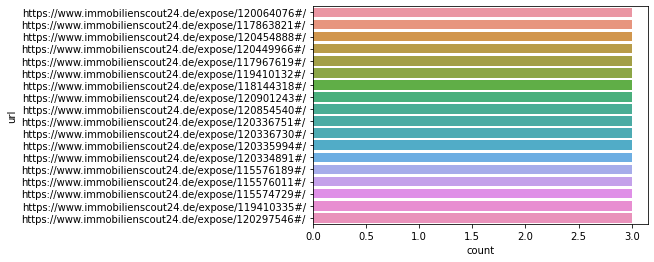

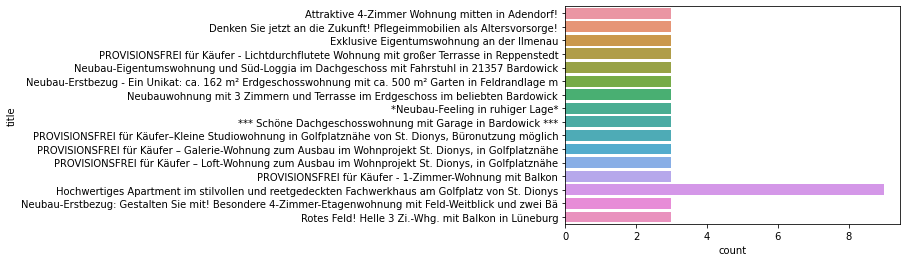

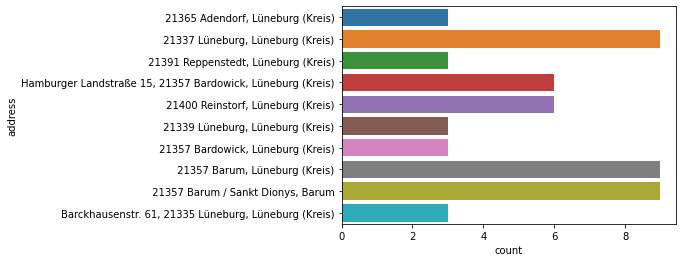

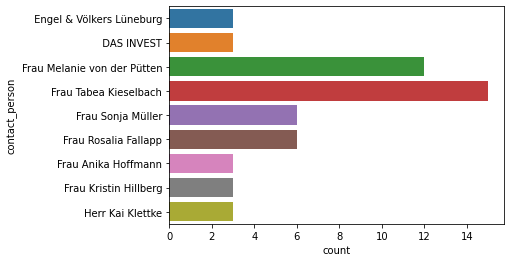

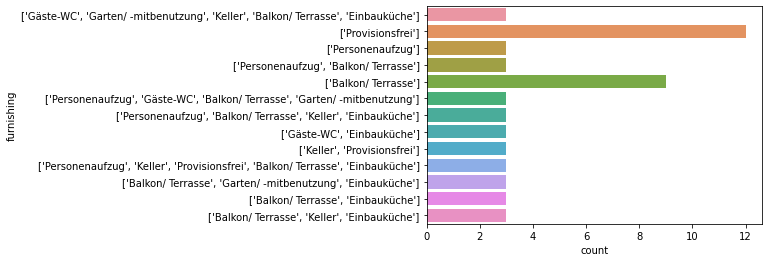

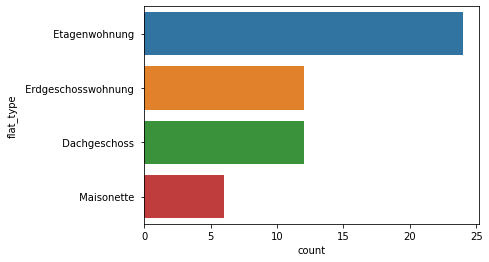

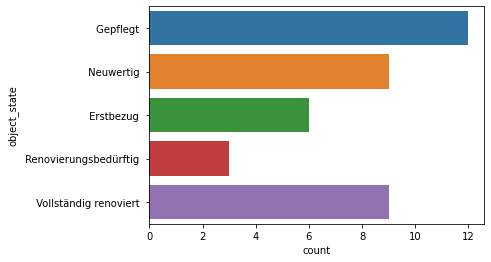

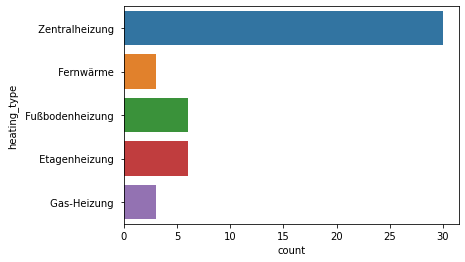

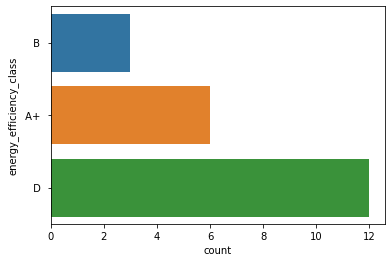

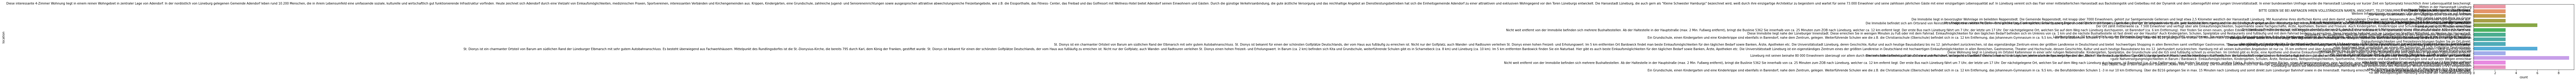

In [13]:
# TODO fix usage of list
# TODO data needs to be fixed
for features in df_base.dtypes[df_base.dtypes == 'object'].index:
    sns.countplot(y=features, data=df_base)
    plt.show()

## Data argmentation
Goal is to calculate the yearly ROI

In [14]:
df_finance = df_base[['url','price_purchase', 'living_area_m2', 'commission_buyer_rate']]
df_finance['price_per_m2'] = df_finance['price_purchase'] / df_finance['living_area_m2']
df_finance['notary_costs'] = notary_percentage * df_finance['price_purchase']

df_finance['land_registry_tax'] = land_registry_tax_percentage * df_finance['price_purchase']
df_finance['real_estate_transfer_tax'] = transfer_tax_percentage * df_finance['price_purchase']
df_finance['commission'] = df_finance['price_purchase'] * df_finance['commission_buyer_rate'] * 0.01 # TODO fix while parsing from scraper already
df_finance['total_buying_price'] = df_finance['price_purchase'] + df_finance['notary_costs'] + df_finance['land_registry_tax'] + df_finance['real_estate_transfer_tax'] + df_finance['commission']
df_finance['equity'] = equity_percentage * df_finance['total_buying_price']
df_finance['debt'] = df_finance['total_buying_price'] - df_finance['equity']
df_finance['interest_rate_monthly'] = interest_rate * df_finance['debt'] / 12
df_finance['mortgage_payment_yearly'] = mortgage_payment_rate * df_finance['debt']
df_finance['mortgage_payment_monthly'] = df_finance['mortgage_payment_yearly'] / 12
df_finance['monthly_rent'] = rent_price_index * df_finance['living_area_m2']
df_finance['additional_costs'] = additional_costs_rate_per_m2 * df_finance['living_area_m2']
df_finance['cashflow'] = df_finance['monthly_rent'] - df_finance['interest_rate_monthly'] - df_finance['mortgage_payment_monthly'] - df_finance['additional_costs']
df_finance['ROI'] = (df_finance['cashflow'] * 12) / df_finance['equity'] 





In [15]:
df_finance.sort_values(by=['ROI'], ascending=False)

,url,price_purchase,living_area_m2,commission_buyer_rate,price_per_m2,notary_costs,land_registry_tax,real_estate_transfer_tax,commission,total_buying_price,equity,debt,interest_rate_monthly,mortgage_payment_yearly,mortgage_payment_monthly,monthly_rent,additional_costs,cashflow,ROI
28,https://www.immobilienscout24.de/expose/120336730#/,217620,117.00,0.00,1860.000000,3264.3,1088.1,10881.0,0.0,232853.4,46570.68,186282.72,155.235600,3725.6544,310.471200,1053.00,105.300,481.9932,0.124197
10,https://www.immobilienscout24.de/expose/120336730#/,217620,117.00,0.00,1860.000000,3264.3,1088.1,10881.0,0.0,232853.4,46570.68,186282.72,155.235600,3725.6544,310.471200,1053.00,105.300,481.9932,0.124197
46,https://www.immobilienscout24.de/expose/120336730#/,217620,117.00,0.00,1860.000000,3264.3,1088.1,10881.0,0.0,232853.4,46570.68,186282.72,155.235600,3725.6544,310.471200,1053.00,105.300,481.9932,0.124197
29,https://www.immobilienscout24.de/expose/120335994#/,115320,62.00,0.00,1860.000000,1729.8,576.6,5766.0,0.0,123392.4,24678.48,98713.92,82.261600,1974.2784,164.523200,558.00,55.800,255.4152,0.124197
11,https://www.immobilienscout24.de/expose/120335994#/,115320,62.00,0.00,1860.000000,1729.8,576.6,5766.0,0.0,123392.4,24678.48,98713.92,82.261600,1974.2784,164.523200,558.00,55.800,255.4152,0.124197
47,https://www.immobilienscout24.de/expose/120335994#/,115320,62.00,0.00,1860.000000,1729.8,576.6,5766.0,0.0,123392.4,24678.48,98713.92,82.261600,1974.2784,164.523200,558.00,55.800,255.4152,0.124197
26,https://www.immobilienscout24.de/expose/120854540#/,139000,66.14,6.95,2101.602661,2085.0,695.0,6950.0,9660.5,158390.5,31678.10,126712.40,105.593667,2534.2480,211.187333,595.26,59.526,218.9530,0.082942
8,https://www.immobilienscout24.de/expose/120854540#/,139000,66.14,6.95,2101.602661,2085.0,695.0,6950.0,9660.5,158390.5,31678.10,126712.40,105.593667,2534.2480,211.187333,595.26,59.526,218.9530,0.082942
44,https://www.immobilienscout24.de/expose/120854540#/,139000,66.14,6.95,2101.602661,2085.0,695.0,6950.0,9660.5,158390.5,31678.10,126712.40,105.593667,2534.2480,211.187333,595.26,59.526,218.9530,0.082942
30,https://www.immobilienscout24.de/expose/120334891#/,106000,41.00,0.00,2585.365854,1590.0,530.0,5300.0,0.0,113420.0,22684.00,90736.00,75.613333,1814.7200,151.226667,369.00,36.900,105.2600,0.055683


In [16]:
df_finance[(df_finance['cashflow'] > 0) ].sort_values(by=['ROI'], ascending=False)

,url,price_purchase,living_area_m2,commission_buyer_rate,price_per_m2,notary_costs,land_registry_tax,real_estate_transfer_tax,commission,total_buying_price,equity,debt,interest_rate_monthly,mortgage_payment_yearly,mortgage_payment_monthly,monthly_rent,additional_costs,cashflow,ROI
28,https://www.immobilienscout24.de/expose/120336730#/,217620,117.00,0.00,1860.000000,3264.3,1088.1,10881.0,0.0,232853.4,46570.68,186282.72,155.235600,3725.6544,310.471200,1053.00,105.300,481.9932,0.124197
46,https://www.immobilienscout24.de/expose/120336730#/,217620,117.00,0.00,1860.000000,3264.3,1088.1,10881.0,0.0,232853.4,46570.68,186282.72,155.235600,3725.6544,310.471200,1053.00,105.300,481.9932,0.124197
10,https://www.immobilienscout24.de/expose/120336730#/,217620,117.00,0.00,1860.000000,3264.3,1088.1,10881.0,0.0,232853.4,46570.68,186282.72,155.235600,3725.6544,310.471200,1053.00,105.300,481.9932,0.124197
47,https://www.immobilienscout24.de/expose/120335994#/,115320,62.00,0.00,1860.000000,1729.8,576.6,5766.0,0.0,123392.4,24678.48,98713.92,82.261600,1974.2784,164.523200,558.00,55.800,255.4152,0.124197
11,https://www.immobilienscout24.de/expose/120335994#/,115320,62.00,0.00,1860.000000,1729.8,576.6,5766.0,0.0,123392.4,24678.48,98713.92,82.261600,1974.2784,164.523200,558.00,55.800,255.4152,0.124197
29,https://www.immobilienscout24.de/expose/120335994#/,115320,62.00,0.00,1860.000000,1729.8,576.6,5766.0,0.0,123392.4,24678.48,98713.92,82.261600,1974.2784,164.523200,558.00,55.800,255.4152,0.124197
26,https://www.immobilienscout24.de/expose/120854540#/,139000,66.14,6.95,2101.602661,2085.0,695.0,6950.0,9660.5,158390.5,31678.10,126712.40,105.593667,2534.2480,211.187333,595.26,59.526,218.9530,0.082942
8,https://www.immobilienscout24.de/expose/120854540#/,139000,66.14,6.95,2101.602661,2085.0,695.0,6950.0,9660.5,158390.5,31678.10,126712.40,105.593667,2534.2480,211.187333,595.26,59.526,218.9530,0.082942
44,https://www.immobilienscout24.de/expose/120854540#/,139000,66.14,6.95,2101.602661,2085.0,695.0,6950.0,9660.5,158390.5,31678.10,126712.40,105.593667,2534.2480,211.187333,595.26,59.526,218.9530,0.082942
48,https://www.immobilienscout24.de/expose/120334891#/,106000,41.00,0.00,2585.365854,1590.0,530.0,5300.0,0.0,113420.0,22684.00,90736.00,75.613333,1814.7200,151.226667,369.00,36.900,105.2600,0.055683


In [17]:
df_finance[(df_finance['cashflow'] > 0) & (df_finance['equity'] <= 25000) ].sort_values(by=['ROI'], ascending=False)

,url,price_purchase,living_area_m2,commission_buyer_rate,price_per_m2,notary_costs,land_registry_tax,real_estate_transfer_tax,commission,total_buying_price,equity,debt,interest_rate_monthly,mortgage_payment_yearly,mortgage_payment_monthly,monthly_rent,additional_costs,cashflow,ROI
11,https://www.immobilienscout24.de/expose/120335994#/,115320,62.0,0.0,1860.000000,1729.8,576.6,5766.0,0.0,123392.4,24678.48,98713.92,82.261600,1974.2784,164.523200,558.0,55.8,255.4152,0.124197
29,https://www.immobilienscout24.de/expose/120335994#/,115320,62.0,0.0,1860.000000,1729.8,576.6,5766.0,0.0,123392.4,24678.48,98713.92,82.261600,1974.2784,164.523200,558.0,55.8,255.4152,0.124197
47,https://www.immobilienscout24.de/expose/120335994#/,115320,62.0,0.0,1860.000000,1729.8,576.6,5766.0,0.0,123392.4,24678.48,98713.92,82.261600,1974.2784,164.523200,558.0,55.8,255.4152,0.124197
12,https://www.immobilienscout24.de/expose/120334891#/,106000,41.0,0.0,2585.365854,1590.0,530.0,5300.0,0.0,113420.0,22684.00,90736.00,75.613333,1814.7200,151.226667,369.0,36.9,105.2600,0.055683
30,https://www.immobilienscout24.de/expose/120334891#/,106000,41.0,0.0,2585.365854,1590.0,530.0,5300.0,0.0,113420.0,22684.00,90736.00,75.613333,1814.7200,151.226667,369.0,36.9,105.2600,0.055683
48,https://www.immobilienscout24.de/expose/120334891#/,106000,41.0,0.0,2585.365854,1590.0,530.0,5300.0,0.0,113420.0,22684.00,90736.00,75.613333,1814.7200,151.226667,369.0,36.9,105.2600,0.055683
